# Caso Práctico - ENGIE

*Jose Enrique Zafra Mena*

## Introducción


## Carga de datos

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl

In [86]:
facturas_df=pd.read_excel('facturas.xlsx')
mapping_df=pd.read_excel('Mapping.xlsx')

# renombramos los Deals
CTV_df=pd.read_excel('JVLNG_CTV_STOK_MARZO_2024_05_23_14_12.xlsx')
IAC_df=pd.read_excel('MEDG2_IAC_GETRA_MARZO_2024_05_23_14_12.xlsx')
AOC2_df=pd.read_excel('SUGS2_AOC_STOK_MARZO_2024_05_23_14_12.xlsx')
AOC_df=pd.read_excel('SUGST_AOC_STOK_MARZO_2024_05_23_14_12.xlsx')


In [87]:
mapping_df.head()

,Origen,Servicio facturado,Portfolio,Commodity,DealType
0,C.I. Almería,Entrada PVB,MEDG2,IAC,GETRA
1,TVB,PLANTAS,JVLNG,ICC,GETRA
2,TVB,PLANTAS,JVLNG,ICC,GETRA
3,TVB,PLANTAS,JVLNG,ICC,GETRA
4,TVB,PLANTAS,JVLNG,ICC,GETRA


## Transformación de los datos


### Mapping
Quitamos los duplicados y todas las Commoditys que no necesitamos: nos quedamos solo con CTV, IAC, AOC. También escribimos bien los tipos de Servicios Facturados.

In [88]:
mapping_df=mapping_df.query("Commodity in ['CTV', 'IAC', 'AOC'] and Portfolio in ['MEDG2','JVLNG', 'SUGST', 'SUGS2']").drop_duplicates()

# cambiamos los nombres
fixes = {
    'ExtracciÃ³n':'Extracción',
    'InyecciÃ³n':'Inyección'
}

mapping_df['Servicio facturado'] = mapping_df['Servicio facturado'].replace(fixes)

mapping_df.head(15)

,Origen,Servicio facturado,Portfolio,Commodity,DealType
0,C.I. Almería,Entrada PVB,MEDG2,IAC,GETRA
16,TVB,Almacenamiento TVB,JVLNG,CTV,STOK
25,AVB,Servicio agregado AVB,SUGST,AOC,STOK
26,AVB,Extracción,SUGST,AOC,STOK
27,AVB,Salida PVB a AVB,SUGST,AOC,STOK
28,AVB,Inyección,SUGST,AOC,STOK
29,AVB,Entrada PVB desde AVB,SUGST,AOC,STOK
30,AVB,Almacenamiento AVB,SUGST,AOC,STOK
31,AVB,Servicio agregado AVB,SUGS2,AOC,STOK
32,AVB,Extracción,SUGS2,AOC,STOK


### Facturas
Quitamos columnas que no son relevantes, ajustamos formato de las fechas, y reordenamos columnas:

In [89]:
mapping_df.rename(columns={'Servicio facturado': 'Servicio Facturado'}, inplace=True)

facturas_new_df = facturas_df.loc[:, ['NumeroFactura', 'Importe', 'FechaFactura', 'Origen', 'ServicioFacturado']]

facturas_new_df.rename(columns={'NumeroFactura': 'Número de Factura', 'Importe':'Importe Factura', 'FechaFactura':'Fecha Factura',
                                'ServicioFacturado':'Servicio Facturado'}, inplace=True)

facturas_new_df['Fecha Factura'] = pd.to_datetime(facturas_new_df['Fecha Factura'], format="%d/%m/%y")

#facturas_new_df['Fecha Factura 2'] = facturas_new_df['Fecha Factura'].dt.strftime('%d/%m/%Y') # con esto dejan de ser datetime64, pero es mejor para verlo directamente

facturas_new_df.head(20)

,Número de Factura,Importe Factura,Fecha Factura,Origen,Servicio Facturado
0,2024264672,123195.13,2024-03-04,AVB,Servicio agregado AVB
1,2024264671,111963.62,2024-03-04,AVB,Servicio agregado AVB
2,2324004231,503763.47,2024-03-06,C.I. Almería,Entrada PVB
3,2024164592,1375.12,2024-03-04,TVB,Almacenamiento TVB
4,2024164591,1787.43,2024-03-04,TVB,Almacenamiento TVB
5,2024164590,1930.23,2024-03-04,TVB,Almacenamiento TVB
6,2024164589,1472.13,2024-03-04,TVB,Almacenamiento TVB
7,2024164588,1965.66,2024-03-04,TVB,Almacenamiento TVB
8,2024164587,1041.67,2024-03-04,TVB,Almacenamiento TVB
9,2024164586,1030.97,2024-03-04,TVB,Almacenamiento TVB


### Deals
Los Deals tienen columnas que no necesitamos para la conciliación. 

In [90]:
# escogemos las columnas que queremos de cada Deal
CTV_min_df = CTV_df.loc[:,['Id', 'TotalQuantity','Strike', 'TradeDate', 'CommodityType','Direction']]
IAC_min_df = IAC_df.loc[:,['Id', 'Quantity', 'TradeDate', 'CommodityType','Direction']] ## crear strikes con 0s
AOC_min_df = AOC_df.loc[:,['Id', 'TotalQuantity','Strike', 'TradeDate', 'CommodityType','Direction']]
AOC2_min_df = AOC2_df.loc[:,['Id', 'TotalQuantity','Strike', 'TradeDate', 'CommodityType','Direction']]

# como IAC son todos compras, no tiene strikes. Creamos esa columna de ceros
IAC_min_df['Strike']=0

# creamos una columna en todos para el importe, no en todos se puede hallar igual
CTV_min_df['Importe'] = CTV_min_df['TotalQuantity']  # mal definido
IAC_min_df['Importe'] = IAC_min_df['Quantity']*IAC_min_df['Strike']    # mal definido también
AOC_min_df['Importe'] = AOC_min_df['TotalQuantity']*AOC_min_df['Strike']
AOC2_min_df['Importe'] = AOC2_min_df['TotalQuantity']*AOC2_min_df['Strike']

IAC_min_df['Quantity'].rename({'Quantity':'TotalQuantity'}, inplace=True)

AOC_min_df.head(20)

,Id,TotalQuantity,Strike,TradeDate,CommodityType,Direction,Importe
0,41888250,NaN,NaN,2024-02-22T00:00:00+01:00,EG,Buy,NaN
1,38290460,924.588,35.20,2023-04-20T00:00:00+02:00,EG,Sell,32545.49760
2,38249489,352.340,34.55,2023-04-17T00:00:00+02:00,EG,Sell,12173.34700
3,38054569,3910.694,36.76,2023-03-24T00:00:00+01:00,EG,Sell,143757.11144
4,36525979,NaN,NaN,2022-11-16T00:00:00+01:00,EG,Buy,NaN
5,34044001,NaN,NaN,2022-03-09T00:00:00+01:00,EG,Buy,NaN


Vamos a conectar el Mapping con cada Deal, ya que queremos comparar con las facturas.

Para conectar Mapping con CTV usamos Commodity==CTV

Para conectar Mapping con IAC usamos Commodity==IAC

Para conectar Mapping con AOC usamos Commodity==AOC & Portofolio: SUGST

Para conectar Mapping con AOC2 usamos Commodity==AOC & Portofolio: SUGS2


In [91]:
# Añadimos las columnas de Portfolio y Commodity correspondientes 
# en los Deals para poder relacionarlos con el Mapping

CTV_min_df['Portfolio']='JVLNG'
CTV_min_df['Commodity']='CTV'

IAC_min_df['Portfolio']='MEDG2'
IAC_min_df['Commodity']='IAC'

AOC_min_df['Portfolio']='SUGST'
AOC_min_df['Commodity']='AOC'

AOC2_min_df['Portfolio']='SUGS2'
AOC2_min_df['Commodity']='AOC'

AOC_min_df.head()

,Id,TotalQuantity,Strike,TradeDate,CommodityType,Direction,Importe,Portfolio,Commodity
0,41888250,NaN,NaN,2024-02-22T00:00:00+01:00,EG,Buy,NaN,SUGST,AOC
1,38290460,924.588,35.20,2023-04-20T00:00:00+02:00,EG,Sell,32545.49760,SUGST,AOC
2,38249489,352.340,34.55,2023-04-17T00:00:00+02:00,EG,Sell,12173.34700,SUGST,AOC
3,38054569,3910.694,36.76,2023-03-24T00:00:00+01:00,EG,Sell,143757.11144,SUGST,AOC
4,36525979,NaN,NaN,2022-11-16T00:00:00+01:00,EG,Buy,NaN,SUGST,AOC


#### Unión de los *Deals*

In [92]:
# ahora unimos todos los deals en un solo dataframe 
deals_df=pd.concat([CTV_min_df, IAC_min_df, AOC_min_df, AOC2_min_df], ignore_index=True)

# cambiamos el formato de fecha
deals_df['TradeDate'] = (pd.to_datetime(deals_df['TradeDate'], utc=True ,dayfirst=False, format='%Y-%m-%dT%H:%M:%S%z'))

# cambiamos el nombre de la columna
deals_df.rename(columns={'TradeDate':'Fecha Deal'} , inplace=True)

# quitamos la columna vacia quantitys
deals_df.drop(['Quantity'], axis=1, inplace=True)


deals_df.head(100)

,Id,TotalQuantity,Strike,Fecha Deal,CommodityType,Direction,Importe,Portfolio,Commodity
0,42563586,90000.0,0.0,2024-04-28 22:00:00+00:00,EG,Buy,90000.0,JVLNG,CTV
1,42518127,50000.0,0.0,2024-04-24 22:00:00+00:00,EG,Buy,50000.0,JVLNG,CTV
2,42518126,50000.0,0.0,2024-04-24 22:00:00+00:00,EG,Sell,50000.0,JVLNG,CTV
3,42518125,50000.0,0.0,2024-04-24 22:00:00+00:00,EG,Sell,50000.0,JVLNG,CTV
4,42518124,50000.0,0.0,2024-04-24 22:00:00+00:00,EG,Buy,50000.0,JVLNG,CTV
...,...,...,...,...,...,...,...,...,...
58,37671348,900.0,50.5,2023-02-21 23:00:00+00:00,EG,Sell,45450.0,SUGS2,AOC
59,37356869,NaN,NaN,2022-11-20 23:00:00+00:00,EG,Buy,NaN,SUGS2,AOC
60,37186479,NaN,NaN,2023-01-11 23:00:00+00:00,EG,Buy,NaN,SUGS2,AOC
61,36876402,NaN,NaN,2022-12-18 23:00:00+00:00,EG,Buy,NaN,SUGS2,AOC


#### Merge con mapping

In [93]:
# ahora unimos cada uno con mapping
deals_mapped_df = (pd.merge(deals_df, mapping_df,on=['Portfolio', 'Commodity'], how='inner').drop_duplicates())

test=deals_mapped_df.shape[0]-deals_df.shape[0]
print('deals añadidos:',test)

#deals_mapped_df.head(1000)
deals_mapped_df.head(160)

## SALEN DE MÁS PORQUE LA RELACIÓN NO ES ÚNICA, PARA UN MISMO CANAL (PORTOFOLIO+COMMODITY), 
## HAY DISTINTOS SERVICIOS FACTURADOS           

deals añadidos: 95


,Id,TotalQuantity,Strike,Fecha Deal,CommodityType,Direction,Importe,Portfolio,Commodity,Origen,Servicio Facturado,DealType
0,42563586,90000.0,0.0,2024-04-28 22:00:00+00:00,EG,Buy,90000.0,JVLNG,CTV,TVB,Almacenamiento TVB,STOK
1,42518127,50000.0,0.0,2024-04-24 22:00:00+00:00,EG,Buy,50000.0,JVLNG,CTV,TVB,Almacenamiento TVB,STOK
2,42518126,50000.0,0.0,2024-04-24 22:00:00+00:00,EG,Sell,50000.0,JVLNG,CTV,TVB,Almacenamiento TVB,STOK
3,42518125,50000.0,0.0,2024-04-24 22:00:00+00:00,EG,Sell,50000.0,JVLNG,CTV,TVB,Almacenamiento TVB,STOK
4,42518124,50000.0,0.0,2024-04-24 22:00:00+00:00,EG,Buy,50000.0,JVLNG,CTV,TVB,Almacenamiento TVB,STOK
...,...,...,...,...,...,...,...,...,...,...,...,...
153,36572988,NaN,NaN,2022-11-20 23:00:00+00:00,EG,Buy,NaN,SUGS2,AOC,AVB,Extracción,STOK
154,36572988,NaN,NaN,2022-11-20 23:00:00+00:00,EG,Buy,NaN,SUGS2,AOC,AVB,Salida PVB a AVB,STOK
155,36572988,NaN,NaN,2022-11-20 23:00:00+00:00,EG,Buy,NaN,SUGS2,AOC,AVB,Inyección,STOK
156,36572988,NaN,NaN,2022-11-20 23:00:00+00:00,EG,Buy,NaN,SUGS2,AOC,AVB,Entrada PVB desde AVB,STOK


#### Problemas del merge
Para un mismo ID de un Deal, vemos que puede provenir de diferentes servicios facturados. Hacemos un nuevo dataframe con una columna para cada tipo de servicio facturado. Esto solo tiene sentido porque sabemos que no hay muchos tipos de servicios facturados.

In [94]:
deals_copia_df = deals_mapped_df[['Id', 'TotalQuantity','Strike','Importe','Direction' ,'Fecha Deal', 'CommodityType', 'Portfolio','Commodity', 'Origen','DealType','Servicio Facturado']]

# añadimos las columnas con get_dummies (para que sean binarias)
servicios_dummies=pd.get_dummies(deals_copia_df['Servicio Facturado'])

servicios_dummies.head()

,Almacenamiento AVB,Almacenamiento TVB,Entrada PVB,Entrada PVB desde AVB,Extracción,Inyección,Salida PVB a AVB,Servicio agregado AVB
0,False,True,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False


In [95]:
# los añadimos y quitamos la columna de Servicios,
deals_dummies_df = pd.concat([deals_copia_df, servicios_dummies], axis=1)
deals_dummies_df.drop(columns=['Servicio Facturado'], inplace=True)

deals_dummies_df.head(100)

,Id,TotalQuantity,Strike,Importe,Direction,Fecha Deal,CommodityType,Portfolio,Commodity,Origen,DealType,Almacenamiento AVB,Almacenamiento TVB,Entrada PVB,Entrada PVB desde AVB,Extracción,Inyección,Salida PVB a AVB,Servicio agregado AVB
0,42563586,90000.0000,0.00,90000.000000,Buy,2024-04-28 22:00:00+00:00,EG,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False
1,42518127,50000.0000,0.00,50000.000000,Buy,2024-04-24 22:00:00+00:00,EG,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False
2,42518126,50000.0000,0.00,50000.000000,Sell,2024-04-24 22:00:00+00:00,EG,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False
3,42518125,50000.0000,0.00,50000.000000,Sell,2024-04-24 22:00:00+00:00,EG,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False
4,42518124,50000.0000,0.00,50000.000000,Buy,2024-04-24 22:00:00+00:00,EG,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,40089592,281.7058,33.47,9428.693126,Sell,2023-10-08 22:00:00+00:00,EG,SUGS2,AOC,AVB,STOK,False,False,False,False,False,True,False,False
96,40089592,281.7058,33.47,9428.693126,Sell,2023-10-08 22:00:00+00:00,EG,SUGS2,AOC,AVB,STOK,False,False,False,True,False,False,False,False
97,40089592,281.7058,33.47,9428.693126,Sell,2023-10-08 22:00:00+00:00,EG,SUGS2,AOC,AVB,STOK,True,False,False,False,False,False,False,False
98,38410189,1178.1630,34.26,40363.864380,Sell,2023-05-02 22:00:00+00:00,EG,SUGS2,AOC,AVB,STOK,False,False,False,False,False,False,False,True


In [96]:
# ahora tenemos que tomar, para cada ID único, ver de todos los servicios de los que viene
# se puede hacer con un for, pero groupby es más eficiente

entradas = ['Almacenamiento AVB', 'Almacenamiento TVB', 'Entrada PVB', 'Entrada PVB desde AVB','Extracción', 'Inyección', 'Salida PVB a AVB', 'Servicio agregado AVB']

# agrupamos por id y usamos any,
entradas_grouped = deals_dummies_df.groupby('Id')[entradas].any()
no_entradas = [ 'TotalQuantity','Strike','Importe','Direction' ,'Fecha Deal', 'CommodityType', 'Portfolio','Commodity', 'Origen','DealType']
no_entradas_grouped = deals_dummies_df.groupby('Id')[no_entradas].first()


deals_final_df = no_entradas_grouped.join(entradas_grouped).reset_index()

deals_final_df.head(100)

,Id,TotalQuantity,Strike,Importe,Direction,Fecha Deal,CommodityType,Portfolio,Commodity,Origen,DealType,Almacenamiento AVB,Almacenamiento TVB,Entrada PVB,Entrada PVB desde AVB,Extracción,Inyección,Salida PVB a AVB,Servicio agregado AVB
0,31915597,NaN,NaN,NaN,Buy,2021-08-11 22:00:00+00:00,EG,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False
1,34044001,NaN,NaN,NaN,Buy,2022-03-08 23:00:00+00:00,EG,SUGST,AOC,AVB,STOK,True,False,False,True,True,True,True,True
2,34833331,NaN,NaN,NaN,Buy,2022-05-23 22:00:00+00:00,EG,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False
3,34835329,NaN,NaN,NaN,Buy,2022-05-24 22:00:00+00:00,EG,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False
4,34935869,4372.765,0.0,4372.765,Buy,2022-05-31 22:00:00+00:00,EG,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,42518124,50000.000,0.0,50000.000,Buy,2024-04-24 22:00:00+00:00,EG,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False
59,42518125,50000.000,0.0,50000.000,Sell,2024-04-24 22:00:00+00:00,EG,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False
60,42518126,50000.000,0.0,50000.000,Sell,2024-04-24 22:00:00+00:00,EG,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False
61,42518127,50000.000,0.0,50000.000,Buy,2024-04-24 22:00:00+00:00,EG,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False


Con esto tenemos un dataframe de Deals con Ids únicos, y columnas que nos indican desde qué servicios provienen.

#### Filtrado de fechas
Los trades no ocurren a la vez que las facturas. En general, las facturas se generan después. Como solo tenemos las fecturas de principio de marzo, esa es la cota superior. Probamos con cotas inferiores hasta tener el mismo número de deals que de facturas (14):

In [97]:
deals_marzo_df = deals_final_df[(deals_final_df['Fecha Deal'] >= '2023-7-04') & (deals_final_df['Fecha Deal'] <= '2024-03-31')] 
print(deals_marzo_df.loc[deals_marzo_df['Almacenamiento TVB']==True,'TotalQuantity'].sum() )

deals_marzo_df.head(15)

262000.0


,Id,TotalQuantity,Strike,Importe,Direction,Fecha Deal,CommodityType,Portfolio,Commodity,Origen,DealType,Almacenamiento AVB,Almacenamiento TVB,Entrada PVB,Entrada PVB desde AVB,Extracción,Inyección,Salida PVB a AVB,Servicio agregado AVB
30,39057923,NaN,0.000000,NaN,Buy,2023-07-04 22:00:00+00:00,RES,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False
31,39705811,NaN,NaN,NaN,Buy,2023-09-05 22:00:00+00:00,EG,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False
32,39942100,NaN,NaN,NaN,Buy,2023-09-26 22:00:00+00:00,EG,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False
33,39980344,NaN,NaN,NaN,Buy,2023-09-28 22:00:00+00:00,EG,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False
34,40089592,281.70580,33.470000,9428.693126,Sell,2023-10-08 22:00:00+00:00,EG,SUGS2,AOC,AVB,STOK,True,False,False,True,True,True,True,True
35,40094436,897.70579,44.051106,39544.932795,Sell,2023-10-16 22:00:00+00:00,EG,SUGS2,AOC,AVB,STOK,True,False,False,True,True,True,True,True
36,41888250,NaN,NaN,NaN,Buy,2024-02-21 23:00:00+00:00,EG,SUGST,AOC,AVB,STOK,True,False,False,True,True,True,True,True
37,41985669,50000.00000,0.000000,50000.000000,Sell,2024-02-28 23:00:00+00:00,EG,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False
38,41996650,15000.00000,0.000000,0.000000,Buy,2024-02-29 23:00:00+00:00,EG,SUGS2,AOC,AVB,STOK,True,False,False,True,True,True,True,True
39,42238676,91000.00000,0.000000,91000.000000,Sell,2024-03-25 23:00:00+00:00,EG,JVLNG,CTV,TVB,STOK,False,True,False,False,False,False,False,False


In [152]:
## borrar
facturas_new_df.head(15)

,Número de Factura,Importe Factura,Fecha Factura,Origen,Servicio Facturado
0,2024264672,123195.13,2024-03-04,AVB,Servicio agregado AVB
1,2024264671,111963.62,2024-03-04,AVB,Servicio agregado AVB
2,2324004231,503763.47,2024-03-06,C.I. Almería,Entrada PVB
3,2024164592,1375.12,2024-03-04,TVB,Almacenamiento TVB
4,2024164591,1787.43,2024-03-04,TVB,Almacenamiento TVB
5,2024164590,1930.23,2024-03-04,TVB,Almacenamiento TVB
6,2024164589,1472.13,2024-03-04,TVB,Almacenamiento TVB
7,2024164588,1965.66,2024-03-04,TVB,Almacenamiento TVB
8,2024164587,1041.67,2024-03-04,TVB,Almacenamiento TVB
9,2024164586,1030.97,2024-03-04,TVB,Almacenamiento TVB


## Análisis de los datos

### Facturas
En las facturas todo son compras. Esto ya implica que no podemos establecer relaciones unívocas con los datos de los deals, ya que en estos los datos significativos son solo las ventas.

Podemos hallar el número total de las facturas con su importe total, pero es difícil asignarle una categoría. Lo único que tiene sentido es clasificar por su servicio facturado.

In [57]:
# Número total de facturas
numero_total_facturas = facturas_new_df['Número de Factura'].count()
print('Número total de facturas: ',numero_total_facturas)
# Importe total de facturas 
importe_total_facturas = facturas_new_df['Importe Factura'].sum()
print('Importe total de facturas: '  + f'{importe_total_facturas:.2f}'+' €' )

# Distribución por categoría



Número total de facturas:  14
Importe total de facturas: 811357.98 €


### Deals
Aquí tenemos varias opciones para clasificar. Las únicas que son representativas para este análisis son en función de la dirección (compra/venta), en función del tipo de Commodity, y en función del tiempo.


In [100]:
# Número total de Deals
numero_total_deals = deals_df['Id'].nunique()
volumen_deals = deals_df['Importe'].sum()

print('Número total de deals: ', numero_total_deals)
print('Volumen deals: '+ f'{volumen_deals:.2f}'+' €')

Número total de deals:  63
Volumen deals: 2577039.34 €


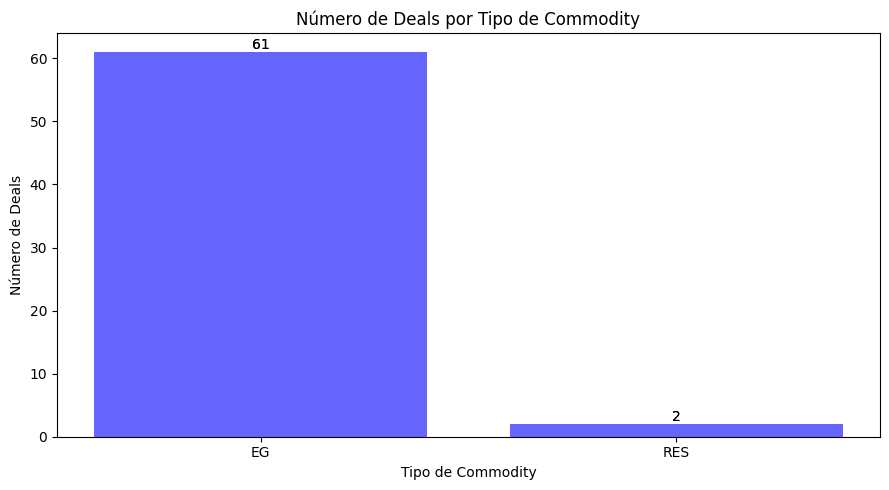

In [104]:
# grouby por 'CommodityType' y calcular el número de trades y el volumen total
agg_df = deals_df.groupby('CommodityType').agg(
    Numero_deals=('Id', 'count'),
    Volumen_Total=('Importe', 'sum')
).reset_index()


# primer gráfico para el número de trades
plt.figure(figsize=(9,5))

plt.subplot(1, 1, 1)
bars = plt.bar(agg_df['CommodityType'], agg_df['Numero_deals'], color='b', alpha=0.6)
plt.xlabel('Tipo de Commodity')
plt.ylabel('Número de Deals')
plt.title('Número de Deals por Tipo de Commodity')

# número de trades encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

# volumen total encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

plt.tight_layout()

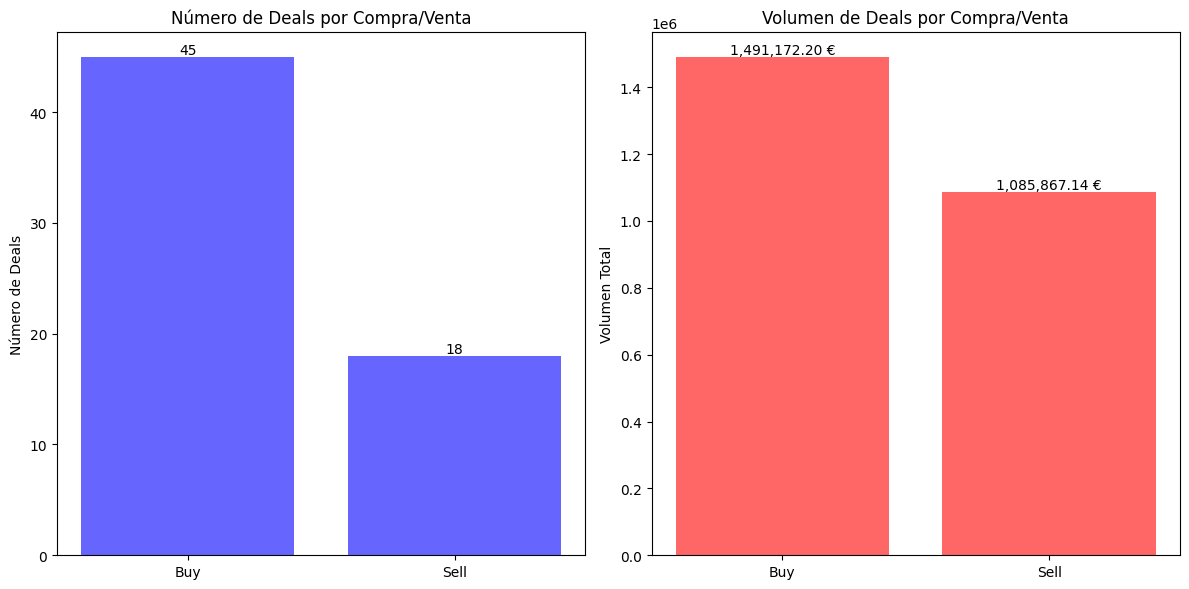

In [105]:
# ahora con la dirección
agg_df = deals_df.groupby('Direction').agg(
    Numero_deals=('Id', 'count'),
    Volumen_Total=('Importe', 'sum')
).reset_index()

# primer gráfico para el número de trades
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
bars = plt.bar(agg_df['Direction'], agg_df['Numero_deals'], color='b', alpha=0.6)
plt.ylabel('Número de Deals')
plt.title('Número de Deals por Compra/Venta')

# número de trades encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

# segundo gráfico para el volumen total
plt.subplot(1, 2, 2)
bars = plt.bar(agg_df['Direction'], agg_df['Volumen_Total'], color='r', alpha=0.6)
plt.ylabel('Volumen Total')
plt.title('Volumen de Deals por Compra/Venta')

# volumen total encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:,.2f} €', ha='center', va='bottom')

plt.tight_layout()

In [ ]:
# grouby por 'CommodityType' y calcular el número de trades y el volumen total
agg_df = deals_df.groupby('CommodityType').agg(
    Numero_deals=('Id', 'count'),
    Volumen_Total=('Importe', 'sum')
).reset_index()


# primer gráfico para el número de trades
plt.figure(figsize=(9,5))

plt.subplot(1, 1, 1)
bars = plt.bar(agg_df['CommodityType'], agg_df['Numero_deals'], color='b', alpha=0.6)
plt.xlabel('Tipo de Commodity')
plt.ylabel('Número de Deals')
plt.title('Número de Deals por Tipo de Commodity')

# número de trades encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

# volumen total encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

plt.tight_layout()

## Conciliación

### Merge de Facturas con los *Deals*

### Unificación de fechas y filtrado

In [156]:
# por ultimo cambio el nombre y el orden de las columnas para verlo mejor
facturas_conciliadas_Marzo_df.rename(columns={'NumeroFactura': 'Número de Factura', 'FechaFactura':'Fecha Factura', 'Id':'ID Deal', 'LegId':'LegID', 
                                              'Quantity':'Importe Deal', 'Importe':'Importe Factura', 'TradeDate':'Fecha Deal'}, inplace=True)

orden = ['Número de Factura', 'ID Deal', 'Importe Factura', 'Importe Deal', 'Fecha Factura', 'Fecha Deal', 'LegID',
         'Origen', 'Servicio Facturado', 'LegType', 'Category', 'Portfolio', 'Commodity', 'DealType', 'Conciliado', 'Observaciones']

facturas_conciliadas_Marzo_df = facturas_conciliadas_Marzo_df.reindex(columns=orden)

facturas_conciliadas_Marzo_df.head(100)

NameError: name 'facturas_conciliadas_Marzo_df' is not defined

## Propuesta de Valor